In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os

import numpy as np

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency
from engaged.features import wave

base_path = os.path.expanduser('~/projects/engaged_hackathon_data/raw_data/cropped_audio/')
dataset_csv = csv.reader(open(base_path + 'below12kHz_cropped_label.txt'))

all_paths = set()    # set of all the original filenames
for single_file_info in dataset_csv:

    wavpath, start_time, wav_class, _ = single_file_info
    original_filename = '_'.join(wavpath.split('_')[:-1])    
    all_paths.add(original_filename)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# discovering which files are not in the other dataset
one_minute_folder = \
    '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files/25_Random/'
four_second_folder = \
    '/home/michael/projects/engaged_hackathon_data/raw_data/cropped_audio/'

unseen_files = []

for x in os.listdir(one_minute_folder):
    if x[:-4] not in all_paths:
        unseen_files.append(x)

print len(unseen_files)

13


In [3]:
# loading in the 4second dataset

filelist = csv.reader(open(base_path + 'below12kHz_cropped_label.txt'))

# dataset is a list of dictionaries, each of which represents one wav file
dataset = [{'wavpath':        f[0], 
            'start_time':     f[1], 
            'class':          f[2].lower().strip(),
            'base_filename':  '_'.join(f[0].split('_')[:3])
           }
           for f in filelist]

print "There are %d items in the original dataset" % len(dataset)

There are 9144 items in the original dataset


NameError: name 'dfd' is not defined

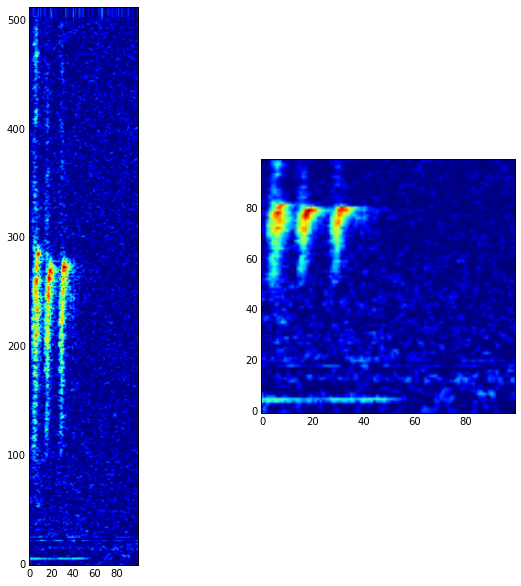

In [4]:
# now take a subset of these files, and take a subset of the spectrogram for each one
from skimage.util.shape import view_as_blocks
import scipy.io.wavfile

# num_files = 10
snippet_length_seconds = 30

slice_width_in_seconds = 0.5

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01
    }

import random

# files_to_use = unseen_files
files_to_use = [datum['wavpath'] for datum in dataset]
# random.sample(unseen_files, num_files)

plt.figure(figsize=(10, 10))
all_slices = []

for count, filepath in enumerate(files_to_use[10:]):
    
    # load file and convrt to spectrogram
    sr, wav = scipy.io.wavfile.read(four_second_folder + filepath)
    spec = frequency.spectrogram(wav, sr, **spectrogram_parameters)[0]
    spec -= np.median(spec, axis=1)[:, None]
#     print spec.shape
# convert spectrogram to mel spaced:
# CAREFUL! Not sure if should be using overlap or window width here...
#     mel_spec = frequency.spec_to_mel(spec, sr, 100)
#     mel_spec -= np.median(mel_spec, axis=1)[:, None]
#     mel_spec[mel_spec<0] = 0
#     plt.subplot(121)
#     spec2 = spec - np.median(spec, axis=1)[:, None]
#     spec2[spec2<0] = 0
#     plt.imshow(spec2[:, :100])
#     plt.gca().invert_yaxis()
#     plt.subplot(122)
#     plt.imshow(mel_spec[:, :100])
#     plt.gca().invert_yaxis()
#     dfd

    slice_width = int(slice_width_in_seconds / spectrogram_parameters['window_width'])
    block_shape = (spectrogram_parameters['nfft']/2, slice_width)
    
    # convert to slices
    max_width = np.floor(spec.shape[1] / slice_width) * slice_width
    spec = np.ascontiguousarray(spec[:, :max_width])

    view = view_as_blocks(spec, block_shape)
    view = np.reshape(view, (-1, block_shape[0] * block_shape[1]))
    
    all_slices.append(view)
    
    print "Done file %d of %d" % (count, len(files_to_use))

In [7]:
all_slices_np = np.vstack(all_slices)
print all_slices_np.shape

(4862, 8192)


In [5]:
from sklearn.cluster import MiniBatchKMeans
all_slices_np = np.vstack(all_slices)

km = MiniBatchKMeans(n_clusters=200)
km.fit(all_slices_np)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=200, n_init=3, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)

In [6]:
# saving the dictionary
import cPickle as pickle
obj = {'km':km, 'slice_width_in_seconds':slice_width_in_seconds}

savepath = '/home/michael/projects/engaged_hackathon_data/dictionaries/200_words.pkl'
pickle.dump(obj, open(savepath, 'w'))

In [7]:
print all_slices_np.shape

(18700, 8192)


In [8]:
# doing pca on this
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(n_components=100)
pca.fit(all_slices_np)

RandomizedPCA(copy=True, iterated_power=3, n_components=100,
       random_state=None, whiten=False)

In [9]:
reconstituted = pca.inverse_transform(pca.transform(all_slices_np))

for count, cen in enumerate(reconstituted[:30]):
    plt.subplot(1, maxi, count+1)    
    plt.imshow(cen.reshape((512, slice_width)))
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.clim(-2.5, 2.5)
    

NameError: name 'maxi' is not defined

In [ ]:
# visualise the cluster centers
plt.figure(figsize=(15, 15))
maxi = 30

for count, cen in enumerate(km.cluster_centers_[30:30+maxi]):
    plt.subplot(1, maxi, count+1)    
    plt.imshow(cen.reshape((512, slice_width)))
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.clim(-2.5, 2.5)

In [ ]:
plt.figure(figsize=(15, 15))
mean_clust = km.cluster_centers_.mean(0)
clust_dists = np.sum((km.cluster_centers_ - mean_clust)**2, axis=1)
sorted_clust_idxs = np.argsort(clust_dists)

plt.plot(clust_dists[sorted_clust_idxs])


for count, idx in enumerate(sorted_clust_idxs[:maxi]):
    plt.subplot(1, maxi, count+1)    
    plt.imshow(km.cluster_centers_[idx].reshape((512, slice_width)))
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.clim(-2.5, 2.5)

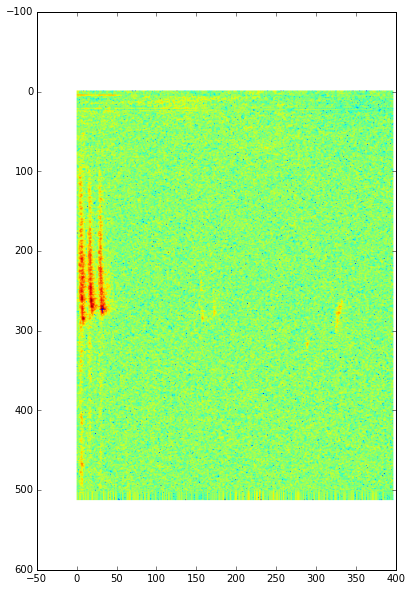

In [16]:
plt.figure(figsize=(10, 10))
spec2 = spec - np.median(spec, axis=1)[:, None]
plt.imshow(spec2)
rows, cols = np.where(spec2 == np.max(spec2)) 
plt.plot(cols, rows, '+b')